#Моя первая сверточная нейросеть :0


## Импортирование библиотек, загрузка стоп-слов и датасета (обзоры фильмов с метками positive/negative)

In [48]:
import re
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

In [49]:
with open('stopwords.txt', 'r', encoding='utf-8') as f:
  sw = f.read()

In [50]:
data = pd.read_csv('IMDB Dataset.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Препроцессинг данных
  - **Чистка данных**
  - **Токенизация + векторизация**  с помощью токенизатора TensorFlow/Keras
  - **Паддинг/усечение** (транкейшн) текстовых последовательностей
  - **Разделение датасета** на обучающую, проверочную и тестовую выборки

In [51]:
import re

def cleaning(text, sw=sw):
  text = text.lower()
  text = re.sub(r'[^a-z\s]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  text = [word for word in text.split() if word not in sw]

  return ' '.join(text)


data['review'] = data['review'].apply(cleaning)
data.head()

,review,sentiment
0,one reviewers mentioned watching just oz episo...,positive
1,wonderful little production br br filming tech...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive


In [53]:
# Разделение данных на текст и метки
texts = data['review'].values
labels = data['sentiment'].map({'positive': 1, 'negative': 0}).values

# Создание слоя TextVectorization
max_tokens = 10000  # Максимальное количество слов в словаре
sequence_length = 200  # Максимальная длина последовательности
vectorizer = TextVectorization(max_tokens=max_tokens, output_mode='int', output_sequence_length=sequence_length)

# Адаптация слоя к данным
vectorizer.adapt(texts)

# Преобразование текста в числовые последовательности
vectorized_texts = vectorizer(texts).numpy()

print("Пример векторизованного текста:", vectorized_texts[1])

# Слой TextVectorization автоматически выполняет паддинг и усечение до указанной длины (output_sequence_length). Если длина текста меньше, он дополняется нулями; если больше — обрезается.

Пример векторизованного текста: [ 271   40  246    2    2 1208 2808    1    1 1467  276    1  395    1
  174 1708  305  291    2    2   60  422   15 2094  369 4361   88    1
 2040 3084  238   12    1  666 9828 1624 1501 7124 6454   15  161   55
    1  311 2181  291 4111  246    5   18 2998  113   44    2    2 1708
   11  155  234   40   82  926 2782  139 1960  883 2946 1091 1000 4806
  181 1629 4363  442   50 3384    1    1  584  442  949    1    1    1
   74 2073 1729   15  123    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0

In [54]:
from sklearn.model_selection import train_test_split

# Разделение данных на обучающую, проверочную и тестовую выборки
X_train, X_temp, y_train, y_temp = train_test_split(vectorized_texts, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Размеры выборок:")
print("Обучающая:", X_train.shape, y_train.shape)
print("Проверочная:", X_val.shape, y_val.shape)
print("Тестовая:", X_test.shape, y_test.shape)

Размеры выборок:
Обучающая: (35000, 200) (35000,)
Проверочная: (7500, 200) (7500,)
Тестовая: (7500, 200) (7500,)


## Построение и компиляция модели

In [55]:
# Параметры модели
embedding_dim = 128  # Размерность эмбеддингов
num_filters = 64  # Количество фильтров в сверточном слое
kernel_size = 4  # Размер ядра свертки
dropout_rate = 0.5  # Процент дропаута

# Создание модели
model = Sequential([
    Embedding(input_dim=max_tokens, output_dim=embedding_dim, input_length=sequence_length),
    Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')  # Выходной слой для бинарной классификации
])

# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Наконец-то! Обучение!

In [56]:
# Обучение модели
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=6,  # Количество эпох
    batch_size=30  # Размер батча
)

Epoch 1/6
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 64s 53ms/step - accuracy: 0.7313 - loss: 0.5021 - val_accuracy: 0.8759 - val_loss: 0.2898
Epoch 2/6
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 81s 52ms/step - accuracy: 0.9331 - loss: 0.1877 - val_accuracy: 0.8776 - val_loss: 0.2947
Epoch 3/6
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 59s 51ms/step - accuracy: 0.9842 - loss: 0.0578 - val_accuracy: 0.8760 - val_loss: 0.3807
Epoch 4/6
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 61s 52ms/step - accuracy: 0.9947 - loss: 0.0187 - val_accuracy: 0.8695 - val_loss: 0.5123
Epoch 5/6
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 80s 51ms/step - accuracy: 0.9962 - loss: 0.0121 - val_accuracy: 0.8747 - val_loss: 0.5897
Epoch 6/6
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 63s 54ms/step - accuracy: 0.9955 - loss: 0.0129 - val_accuracy: 0.8616 - val_loss: 0.6155


## Оценка и визуализация

In [57]:
# Оценка модели на тестовой выборке
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8781 - loss: 0.5587
Точность на тестовой выборке: 0.8692


235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step


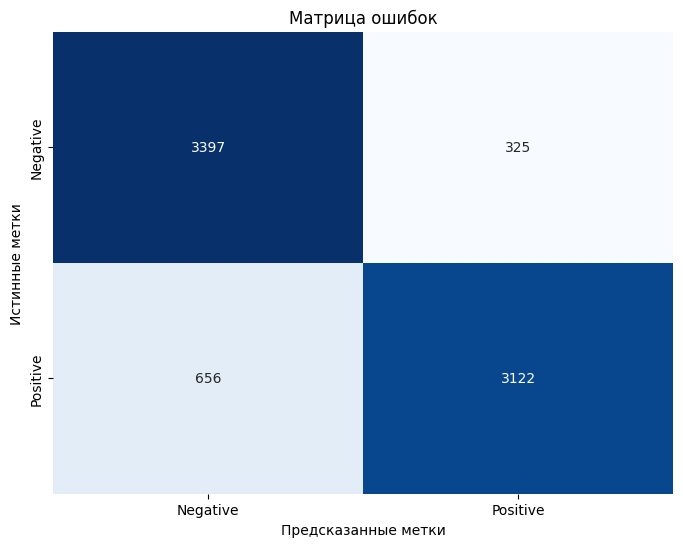

In [58]:
# Получение предсказаний
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Преобразуем вероятности в бинарные метки (0 или 1)

# Создание матрицы ошибок
cm = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

## Поменяем некоторые параметры и посмотрим, станет ли лучше.
Я меняла размерность ядра свертки, количество эпох и размерность батча в качестве эксперимента

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


875/875 ━━━━━━━━━━━━━━━━━━━━ 70s 77ms/step - accuracy: 0.7280 - loss: 0.5117 - val_accuracy: 0.8676 - val_loss: 0.3064
Epoch 2/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 80s 75ms/step - accuracy: 0.9255 - loss: 0.2033 - val_accuracy: 0.8780 - val_loss: 0.3045
Epoch 3/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 80s 74ms/step - accuracy: 0.9800 - loss: 0.0694 - val_accuracy: 0.8707 - val_loss: 0.3788
Epoch 4/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 81s 72ms/step - accuracy: 0.9950 - loss: 0.0193 - val_accuracy: 0.8709 - val_loss: 0.5393
Epoch 5/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 85s 76ms/step - accuracy: 0.9980 - loss: 0.0076 - val_accuracy: 0.8711 - val_loss: 0.6559
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8828 - loss: 0.5752
Точность на тестовой выборке: 0.8736
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


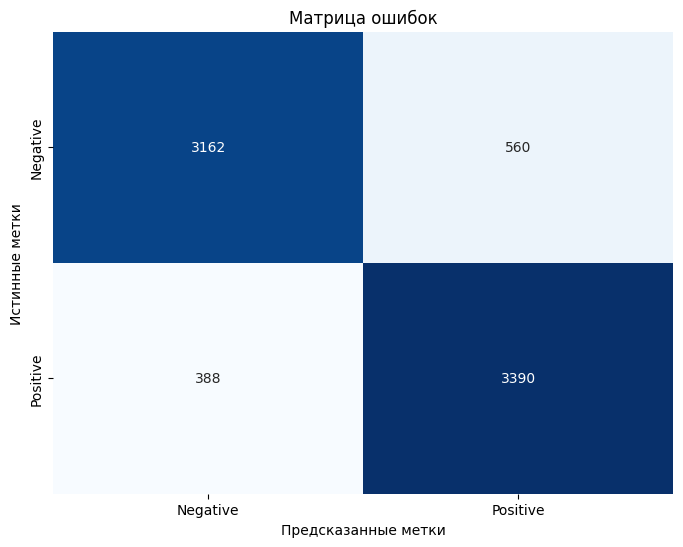

In [61]:
embedding_dim = 128
num_filters = 64
kernel_size = 5  # Увеличила размер ядра с 4 до 5
dropout_rate = 0.5

model = Sequential([
    Embedding(input_dim=max_tokens, output_dim=embedding_dim, input_length=sequence_length),
    Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,  # Уменьшила количество эпох с 6 до 5
    batch_size=40  # Увеличила размер батча с 30 до 40
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

In [63]:
model.save('my_first_CNN.keras')